In [1]:
import torch
from train import setup_model
from utils.load_data import Loader
from utils.utils import load_config

model_name = "codesign_HCDR3_200e"
device = torch.device("cuda:1")
batch_size = 1
seed = 42
num_structures = 100

checkpoint_path = f"/scratch/hz362/datavol/model/{model_name}/epoch=142.ckpt"
load_optimizer = False
config_path = f"/scratch/hz362/datavol/model/{model_name}/config.yaml"

# load model
config = load_config(config_path)
config["num_workers"] = 1
config["batch_size"] = batch_size
config["devices"] = 1
design_mode = config["design_mode"]
model = setup_model(config, checkpoint_path=checkpoint_path, load_optimizer=load_optimizer)

# redesign complex
ds_loader = Loader(config, dataset_name=config["dataset"])

/home/hz362/miniforge3/envs/sabdl/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: Error(s) in loading state_dict for AbFlow:
	Missing key(s) in state_dict: "_network.denoising_module.trunk.invariant_point_attention_0.linear_output.weight", "_network.denoising_module.trunk.invariant_point_attention_0.linear_output.bias", "_network.denoising_module.trunk.invariant_point_attention_1.linear_output.weight", "_network.denoising_module.trunk.invariant_point_attention_1.linear_output.bias", "_network.denoising_module.trunk.invariant_point_attention_2.linear_output.weight", "_network.denoising_module.trunk.invariant_point_attention_2.linear_output.bias", "_network.denoising_module.trunk.invariant_point_attention_3.linear_output.weight", "_network.denoising_module.trunk.invariant_point_attention_3.linear_output.bias". 
	Unexpected key(s) in state_dict: "_network.denoising_module.trunk.invariant_point_attention_0.linear_final.weight", "_network.denoising_module.trunk.invariant_point_attention_0.linear_final.bias", "_network.denoising_module.trunk.invariant_point_attention_1.linear_final.weight", "_network.denoising_module.trunk.invariant_point_attention_1.linear_final.bias", "_network.denoising_module.trunk.invariant_point_attention_2.linear_final.weight", "_network.denoising_module.trunk.invariant_point_attention_2.linear_final.bias", "_network.denoising_module.trunk.invariant_point_attention_3.linear_final.weight", "_network.denoising_module.trunk.invariant_point_attention_3.linear_final.bias". 
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_0.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_1.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_2.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_3.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_4.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_5.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_6.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.condition_module.pairformer_stack.trunk.attention_pair_bias_7.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for _network.confidence_head.pairformer_stack.trunk.attention_pair_bias_0.linear_no_bias_b.weight: copying a param with shape torch.Size([6, 32]) from checkpoint, the shape in current model is torch.Size([16, 32]).

# debug (to be put in write to pdb)

In [7]:
from abflow.structure import write_to_pdb
import os

model.eval()
model.to(device)

data_iter = iter(ds_loader.test_loader)
template_complex = next(data_iter)
template_complex = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in template_complex.items()}
redesign_complexes, redesign_trajs = model._generate_complexes(template_complex, design_mode=design_mode, seed=seed)

des_dir = f"/scratch/hz362/datavol/model/{model_name}/desabs"
if not os.path.exists(des_dir):
    os.makedirs(des_dir)
write_to_pdb(data=template_complex["full_complex"], filepath=f"{des_dir}/full_complex.pdb")
print("true id is", template_complex["full_complex"]["id"])
write_to_pdb(data=template_complex, filepath=f"{des_dir}/WT.pdb")
write_to_pdb(data=redesign_complexes, filepath=f"{des_dir}/DesAb.pdb")
# write traj to pdb - remember plddt per residue is also in redesign_complexes. 
for t, des_t in enumerate(redesign_trajs):
    write_to_pdb(data=des_t, filepath=f"{des_dir}/DesAb_{t}.pdb")

true id is ['4ffv_H_L_A']


## AbFlow

# RAbD evaluation

In [2]:
import torch
from abflow.visualization import plot_plddt, plot_aa_distribution, plot_scatter
from abflow.model.metrics import get_batch_lddt, get_rmsd, get_tm_score, get_aar, get_liability_issues, get_bb_clash_violation, get_bb_bond_angle_violation, get_bb_bond_length_violation
from abflow.data_utils import inv_mask

model.eval()
model.to(device)
test_dataloader = ds_loader.test_loader

def calculate_metrics(true_complex, redesign_complex):
    true_CA_coords = true_complex['CA_coords']
    true_N_coords = true_complex['N_coords']
    true_C_coords = true_complex['C_coords']
    true_CB_coords = true_complex['CB_coords']
    true_res_type = true_complex['res_type']
    redesign_mask = true_complex['redesign_mask']
    antibody_mask = true_complex['antibody_mask']
    antigen_mask = true_complex['antigen_mask']

    pred_CA_coords = redesign_complex['CA_coords']
    pred_N_coords = redesign_complex['N_coords']
    pred_C_coords = redesign_complex['C_coords']
    pred_CB_coords = redesign_complex['CB_coords']
    pred_res_type = redesign_complex['res_type']

    metrics = {
        "fixed_region_aar": get_aar(pred_res_type, true_res_type, masks=[inv_mask(redesign_mask)]).mean().item(),
        "fixed_region_rmsd": get_rmsd([pred_CA_coords], [true_CA_coords], masks=[inv_mask(redesign_mask)]).mean().item(),
        "designed_cdr_aar": get_aar(pred_res_type, true_res_type, masks=[redesign_mask]).mean().item(),
        "designed_cdr_ca_rmsd": get_rmsd([pred_CA_coords], [true_CA_coords], masks=[redesign_mask]).mean().item(),
        "designed_antibody_ca_tm_score": get_tm_score(pred_CA_coords, true_CA_coords, masks=[antibody_mask]).mean().item(),
        "designed_cdr_liability_issues": get_liability_issues(pred_res_type, masks=[redesign_mask]).mean().item(),
        "designed_cdr_bb_clash": get_bb_clash_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks_dim_1=[redesign_mask])[1].mean().item(),
        "designed_cdr_bb_bond_angle_violation": get_bb_bond_angle_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask])[1].mean().item(),
        "designed_cdr_bb_bond_length_violation": get_bb_bond_length_violation(pred_N_coords, pred_CA_coords, pred_C_coords, masks=[redesign_mask])[1].mean().item(),
    }
    return metrics

def average_metrics(all_metrics):
    avg_metrics = {key: sum(d[key] for d in all_metrics) / len(all_metrics) for key in all_metrics[0]}
    return avg_metrics

all_metrics = []

with torch.no_grad():
    res_lddt_list = []
    res_plddt_list = []
    batch_lddt_list = []
    batch_ca_rmsd_list = []
    batch_plddt_list = []
    true_seq_list = []
    pred_seq_list = []
    for test_complex in test_dataloader:
        test_complex = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in test_complex.items()}
        if test_complex["full_complex"]["id"][0].startswith(('3h3b', '3uzq', '2ghw')):
            continue
        test_complex = {k: (v.repeat(num_structures, *[1] * (v.dim() - 1)).to(device) if isinstance(v, torch.Tensor) else v) for k, v in test_complex.items()}
        
        redesign_complex, _ = model._generate_complexes(test_complex, design_mode=design_mode, seed=seed)
        
        metrics = calculate_metrics(test_complex, redesign_complex)
        all_metrics.append(metrics)

        true_CA_coords = test_complex['CA_coords']
        redesign_mask = test_complex['redesign_mask']
        pred_CA_coords = redesign_complex['CA_coords']

        res_lddt = redesign_complex['lddt'][redesign_mask.bool()]
        res_plddt = redesign_complex['plddt'][redesign_mask.bool()]
        batch_lddt = get_batch_lddt(redesign_complex['lddt'], [redesign_mask])
        batch_ca_rmsd = get_rmsd([pred_CA_coords], [true_CA_coords], [redesign_mask])
        batch_plddt = get_batch_lddt(redesign_complex['plddt'], [redesign_mask])
        true_seq = test_complex['res_type'][redesign_mask.bool()]
        pred_seq = redesign_complex['res_type'][redesign_mask.bool()]

        res_lddt_list.append(res_lddt)
        res_plddt_list.append(res_plddt)
        batch_lddt_list.append(batch_lddt)
        batch_ca_rmsd_list.append(batch_ca_rmsd)
        batch_plddt_list.append(batch_plddt)
        true_seq_list.append(true_seq)
        pred_seq_list.append(pred_seq)

        # if id is 4ffv, then break
        if test_complex["full_complex"]["id"][0].startswith('4ffv'):
            break
    
    res_lddt = torch.cat(res_lddt_list, dim=0).cpu()
    res_plddt = torch.cat(res_plddt_list, dim=0).cpu()
    batch_lddt = torch.cat(batch_lddt_list, dim=0).cpu()
    batch_ca_rmsd = torch.cat(batch_ca_rmsd_list, dim=0).cpu()
    batch_plddt = torch.cat(batch_plddt_list, dim=0).cpu()
    true_seq = torch.cat(true_seq_list, dim=0).cpu()
    pred_seq = torch.cat(pred_seq_list, dim=0).cpu()

In [3]:
# Print the results
avg_metrics = average_metrics(all_metrics)
print(f"--- Average metrics (100 samples, 55 RAbD complexes) ---")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value}")
print(f"--- Expect fixed_region_aar to be 1 ---")
print(f"--- Expect fixed_region_rmsd to be 0 ---")

--- Average metrics (100 samples, 55 RAbD complexes) ---
fixed_region_aar: 1.0
fixed_region_rmsd: 0.0
designed_cdr_aar: 0.2680599449033087
designed_cdr_ca_rmsd: 0.0
designed_antibody_ca_tm_score: 1.0
designed_cdr_liability_issues: 0.08439026461406188
designed_cdr_bb_clash: 0.0
designed_cdr_bb_bond_angle_violation: 0.0
designed_cdr_bb_bond_length_violation: 0.0
--- Expect fixed_region_aar to be 1 ---
--- Expect fixed_region_rmsd to be 0 ---


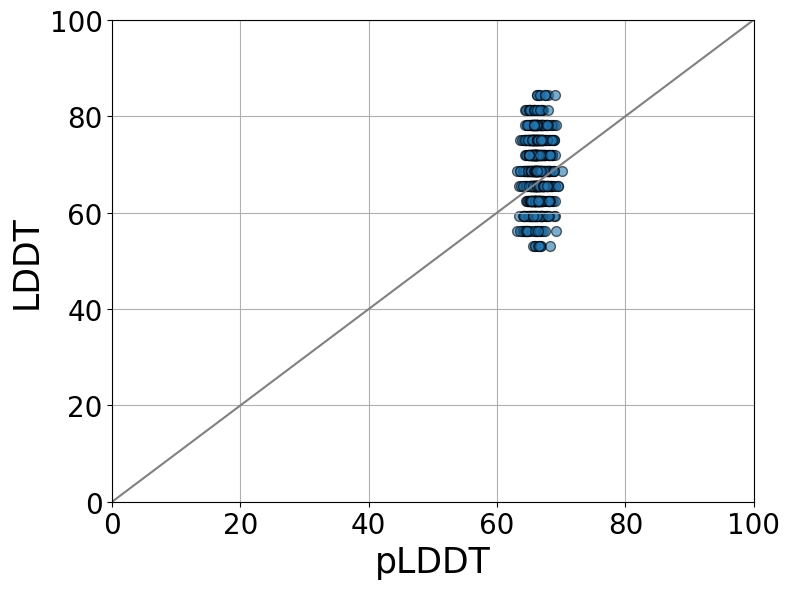

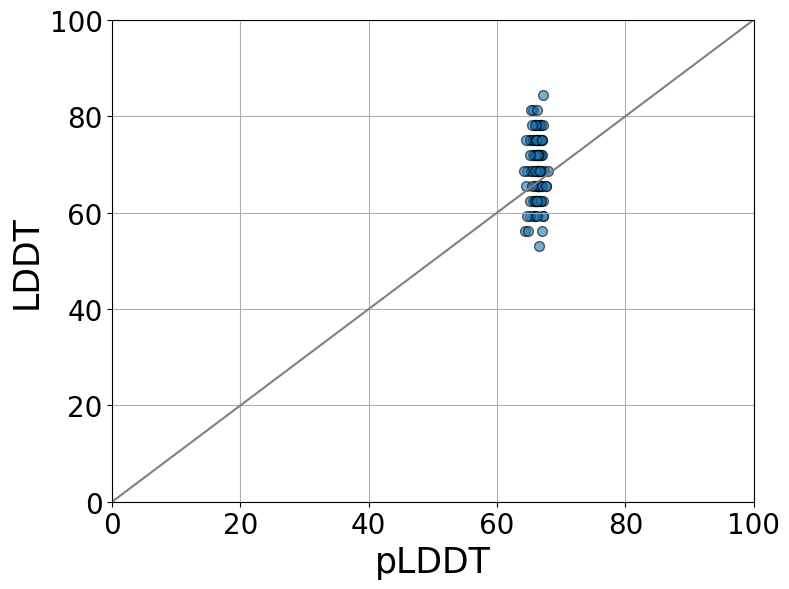

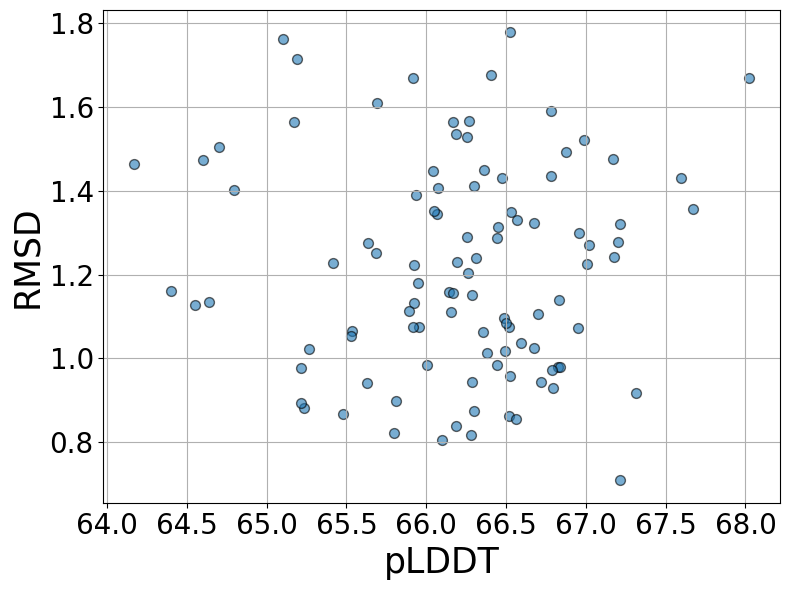

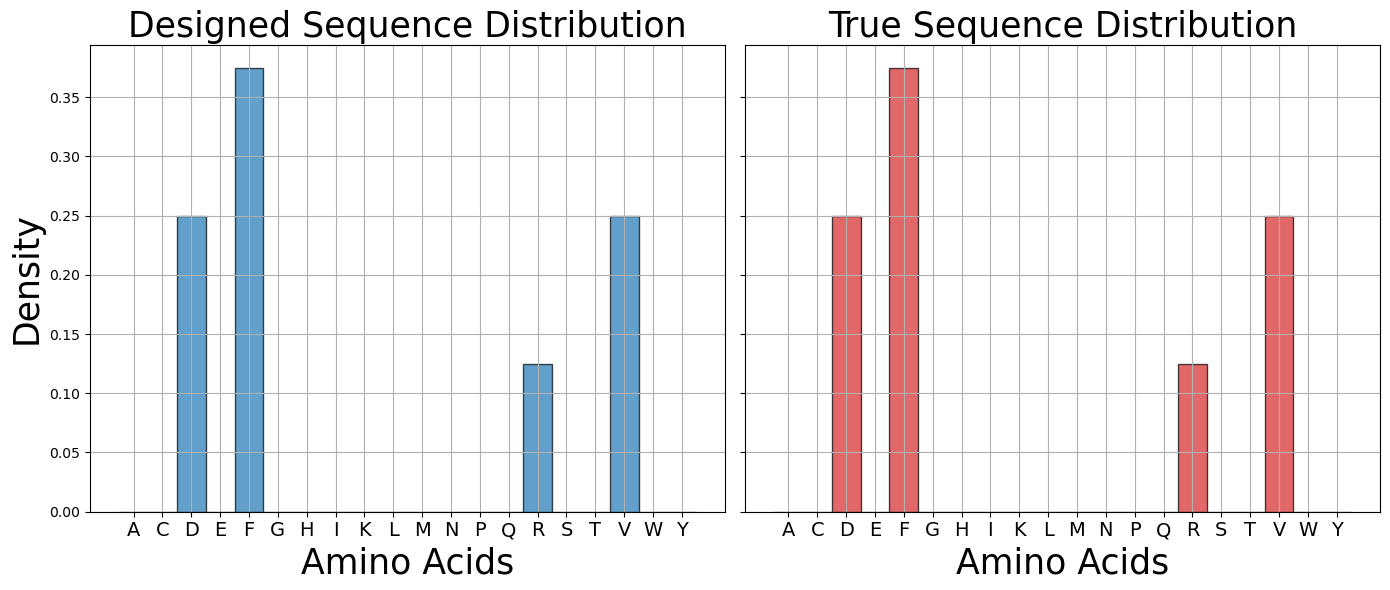

In [3]:
from abflow.visualization import plot_plddt, plot_aa_distribution, plot_scatter

# plot_plddt(lddt, plddt, save_path='./figures/plddt_plot.pdf')
plot_plddt(res_plddt, res_lddt)
plot_plddt(batch_plddt, batch_lddt)
plot_scatter(batch_plddt, batch_ca_rmsd, x_label = "pLDDT", y_label="RMSD")
plot_aa_distribution(pred_seq, true_seq)

# RAbD Benchmark

#### Save the 58 RAbD benchmark pdb files

PDB IDs with chain names are saved in `./data/rabd/rabd.csv`. The following code will download the PDB files and save them in `./data/rabd/pdb/`.

In [2]:
from utils.utils import load_ids_from_csv, fetch_and_load_pdb
import os

rabd_ids = load_ids_from_csv('./data/rabd/rabd.csv')
print("Number of RAbD ids: ", len(rabd_ids))
print("RAbD ids: ", rabd_ids)

save_dir = './data/rabd/pdb/'
os.makedirs(save_dir, exist_ok=True)

for pdb_id_with_chains in rabd_ids:
    try:
        fetch_and_load_pdb(pdb_id_with_chains, save_dir)
    except Exception as e:
        print(f"Failed to save PDB file for {pdb_id_with_chains}: {e}")

Number of RAbD ids:  58
RAbD ids:  ['4ffv_H_L_A', '3hi6_H_L_A', '4cmh_B_C_A', '3h3b_d_D_B', '5hi4_C_D_B', '3cx5_U_V_P', '3nid_E_F_C', '5mes_H_L_A', '1ic7_H_L_Y', '1ncb_H_L_N', '5bv7_C_B_A', '4lvn_C_B_A', '4ki5_E_F_M', '5ggs_C_D_Y', '4etq_H_L_C', '2adf_H_L_A', '5nuz_H_L_D', '4ydk_H_L_G', '3rkd_D_C_B', '2cmr_H_L_A', '5b8c_B_A_C', '3bn9_D_C_B', '5en2_A_B_C', '2xqy_G_L_A', '1a2y_B_A_C', '3o2d_H_L_A', '1fe8_H_L_A', '1n8z_B_A_C', '4g6j_H_L_A', '3mxw_H_L_A', '2b2x_H_L_A', '1osp_H_L_O', '1uj3_B_A_C', '4h8w_H_L_G', '2vxt_H_L_I', '4dvr_H_L_G', '4qci_H_L_C', '3s35_H_L_X', '3w9e_A_B_C', '5f9o_H_L_G', '1iqd_B_A_C', '5d96_J_I_D', '4g6m_H_L_A', '4ot1_H_L_A', '5j13_C_B_A', '5l6y_H_L_C', '3l95_B_A_X', '2xwt_A_B_C', '4fqj_H_L_A', '4dtg_H_L_K', '4xnq_B_A_D', '5d93_C_B_A', '3k2u_H_L_A', '3uzq_A_a_B', '2ghw_B_b_A', '2dd8_H_L_S', '2ypv_H_L_A', '1a14_H_L_N']


## DiffAb

1. git clone diffab into `./benchmarks/`
2. Setup DiffAb env as in: `https://github.com/luost26/diffab` and activate it
3. Download the trained model weights as in: `https://github.com/luost26/diffab` and save it in `./benchmarks/diffab/trained_models/`
4. Run python `./evaluation/radb_diffab_design.py`. diffab do single CDR codesign, single CDR fixed bb sequence design and fix sequence structure prediction on the 58 RAbD benchmark pdb files. The results will be saved in `./benchmarks/diffab/results/`.

In [1]:
import os
from utils.utils import calculate_metrics, average_metrics
from Bio.PDB.PDBExceptions import PDBConstructionException

modes = ["codesign_single", "fixbb", "strpred"]
redesign_cdr = "HCDR3"
scheme = "chothia"
results_dir = "./benchmarks/diffab/results/"
all_avg_metrics = {}

# go through each mode: codesign_single, fixbb, strpred
for mode in modes:
	mode_dir = os.path.join(results_dir, mode)
	mode_metrics = []

	for design_dir in os.listdir(mode_dir):
		design_path = os.path.join(mode_dir, design_dir)
		pdb_id_with_chains = design_dir.split('.')[0]
		true_pdb_path = os.path.join(design_path, "reference.pdb")
		sub_dir = 'H_CDR3'
		sub_dir_path = os.path.join(design_path, sub_dir)
		design_files = [f for f in os.listdir(sub_dir_path) if f.endswith(".pdb")]
		for design_file in design_files:
			pred_pdb_path = os.path.join(sub_dir_path, design_file)
			try:
				metrics = calculate_metrics(true_pdb_path, pred_pdb_path, redesign_cdr, scheme)
				mode_metrics.append(metrics)
			except PDBConstructionException as e:
				print(f"Invalid design file encountered: {pred_pdb_path}")
				print(f"Error: {e}")

	avg_metrics = average_metrics(mode_metrics)
	all_avg_metrics[mode] = avg_metrics

# Print the results
for mode, metrics in all_avg_metrics.items():
    print(f"--- Average metrics for {mode} (100 samples, 55 RAbD complexes) ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
print(f"--- Expect fixed_region_aar to be 1---")
print(f"--- Expect fixed_region_rmsd to be 0---")

Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/5j13_C_B_A.pdb_2024_08_01__10_05_28/H_CDR3/0018.pdb
Error: Invalid or missing coordinate(s) at line 1604.
Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/1ncb_H_L_N.pdb_2024_08_01__17_45_29/H_CDR3/0027.pdb
Error: Invalid or missing coordinate(s) at line 4665.
Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/3w9e_A_B_C.pdb_2024_08_01__14_46_39/H_CDR3/0027.pdb
Error: Invalid or missing coordinate(s) at line 3364.
Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/4g6j_H_L_A.pdb_2024_08_02__10_47_54/H_CDR3/0027.pdb
Error: Invalid or missing coordinate(s) at line 771.
Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/3cx5_U_V_P.pdb_2024_08_01__13_16_02/H_CDR3/0027.pdb
Error: Invalid or missing coordinate(s) at line 2206.
Invalid design file encountered: ./benchmarks/diffab/results/codesign_single/1a2y_B_A_

In [1]:
from abflow.model.metrics import get_liability_issues
import torch

pred_seq_1 = torch.tensor([[11, 5, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 2, 6, 5, 11, 12, 8, 18]])
mask_1 = torch.ones_like(pred_seq_1)
# mask_1 = torch.tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
output_1 = get_liability_issues(pred_seq_1, [mask_1])
print(output_1)

tensor([0.1000, 0.4000])


# dyMEAN

# RosettaAb

# HERN

# dyMEAN